In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.5 MB/s eta 0:00:00


# General setup

In [3]:
import pennylane as qml   # A Python library for quantum machine learning and quantum computing.
from pennylane import numpy as np # This is Pennylane's version of the NumPy library, which is optimized for differentiable quantum operations.
from pennylane.templates import RandomLayers # A pre-defined template in Pennylane that generates random quantum circuits (layers of quantum gates) for testing or experimentation in quantum machine learning.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model


In [11]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Specifies the number of layers in the quantum circuit, likely using the RandomLayers template from PennyLane.
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "D:\Quantum Computing"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Loading of the MNIST dataset

In [12]:
mnist_dataset = keras.datasets.mnist # Loading the MNIST Dataset. 
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()  # Loads the MNIST dataset into training and testing sets

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels. The extra dimension represents the number of channels (grayscale images have 1 channel, while RGB images would have 3 channels).
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Quantum circuit as a convolution kernel

In [13]:
# qml.device; Creates a quantum device to simulate or run quantum circuits.
# default.qubit; Specifies the type of device.
# wires=4; Indicates the number of qubits (quantum wires) in the device
dev = qml.device("default.qubit", wires=4) 
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev) # A decorator that turns the circuit function into a QNode, linking it to the specified quantum device (dev).
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        # qml.RY: Applies a rotation around the Y-axis on the Bloch sphere to each qubit
        # np.pi * phi[j]: The angle of rotation is scaled by 𝜋 and depends on the classical input value ϕ[j].
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    # RandomLayers: A template that applies random quantum gates to the specified wires.
    # rand_params: The randomly generated parameters used to define the gates in the layers.
    # wires=list(range(4)): Applies the random layers to all 4 qubits (indices 0 to 3).
    RandomLayers(rand_params, wires=list(range(4)))

    # qml.expval(qml.PauliZ(j)): Measures the expectation value of the Pauli-Z operator on each qubit.
    # The expectation value provides a real number between −1 and1, representing the likelihood of the qubit being in the ∣0⟩ state versus ∣1⟩.
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# defines the convolution scheme

In [14]:
def quanv(image):  # This code defines a function quanv that performs a quantum-inspired convolution operation on an input image.
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4)) # out is initialized to zeros with dimensions (14, 14, 4).

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit( # q_results stores the output of this quantum circuit, which is assumed to return four expectation values corresponding to four quantum measurement results.
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum pre-processing of the dataset

In [15]:
if PREPROCESS == True: # If False, the program skips preprocessing and directly loads preprocessed data from saved files otherwise the program perform preprocessing.
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


# Let us visualize the effect of the quantum convolution layer on a batch of samples

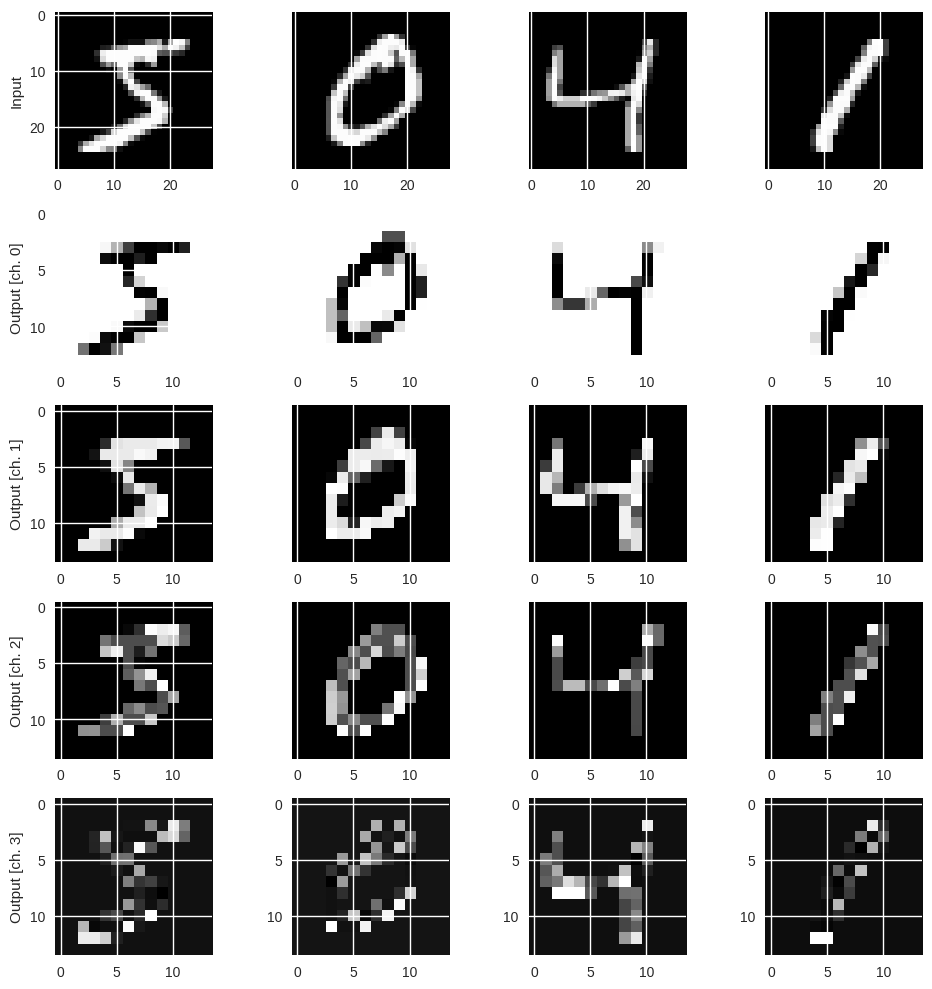

In [16]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Hybrid quantum-classical model

In [17]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([ # keras.models.Sequential: Creates a Sequential model, a linear stack of layers where each layer has one input and one output.
        keras.layers.Flatten(),  # Flattens the input data into a 1D vector.Converts the 2D input images (e.g., 28x28 pixels for MNIST) into a flat array of size 784 (28 × 28 = 784).
        keras.layers.Dense(10, activation="softmax") # Dense: A fully connected layer with 10 output units, corresponding to the 10 possible classes (digits 0–9). 
    ]) #  The softmax activation function converts the raw output values into probabilities, ensuring the outputs sum to 1. This is suitable for multiclass classification tasks.

    model.compile(       # model.compile: Configures the model for training by specifying the optimizer, loss function, and evaluation metrics.
        optimizer='adam', # The Adam optimizer is an adaptive gradient descent algorithm that adjusts learning rates based on the gradient's first and second moments.
        loss="sparse_categorical_crossentropy", # This loss function is used for multiclass classification problems when the labels are integers (e.g., 0, 1, ..., 9 for MNIST).
        metrics=["accuracy"], # Specifies that the model should compute and report accuracy during training and evaluation.
    )
    return model

# Training

In [18]:
q_model = MyModel() # q_model: A new instance of the custom Keras model defined in the MyModel function.

q_history = q_model.fit( # q_model.fit: Trains the model using the training dataset and evaluates it on the validation dataset after each epoch.
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels), 
    batch_size=4, # The number of samples processed before updating the model's weights. A smaller batch size increases training iterations per epoch but may slow down training due to frequent updates.
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - 224ms/step - accuracy: 0.0600 - loss: 2.6696 - val_accuracy: 0.2000 - val_loss: 2.1858
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3400 - loss: 1.9418 - val_accuracy: 0.2333 - val_loss: 2.0242
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5400 - loss: 1.6390 - val_accuracy: 0.3667 - val_loss: 1.8166
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.3204 - val_accuracy: 0.5667 - val_loss: 1.6871
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 1.0862 - val_accuracy: 0.6000 - val_loss: 1.5751
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.9001 - val_accuracy: 0.6333 - val_loss: 1.4814
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.7519 - val_accuracy: 0.6333 - val_loss: 1.4085
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.6363 - val_accuracy: 0.6667 - val_loss: 1.3469
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.5431 - val_accuracy: 0.6667 - val_loss: 1.2961
Epoch 10/30
13/13

# In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [20]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 155ms/step - accuracy: 0.1200 - loss: 2.4711 - val_accuracy: 0.1000 - val_loss: 2.2832
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3200 - loss: 2.0486 - val_accuracy: 0.2000 - val_loss: 2.1461
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5600 - loss: 1.7534 - val_accuracy: 0.3000 - val_loss: 2.0130
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.7800 - loss: 1.5072 - val_accuracy: 0.3667 - val_loss: 1.8858
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.8800 - loss: 1.2997 - val_accuracy: 0.4667 - val_loss: 1.7722
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.8800 - loss: 1.1263 - val_accuracy: 0.5000 - val_loss: 1.6753
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.9824 - val_accuracy: 0.5000 - val_loss: 1.5942
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.8630 - val_accuracy: 0.4667 - val_loss: 1.5263
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 0.7633 - val_accuracy: 0.4667 - val_loss: 1.4690
Epoch 10/30
13/13

# Results

# We can finally plot the test accuracy and the test loss with respect to the number of training epochs.


<ipython-input-21-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


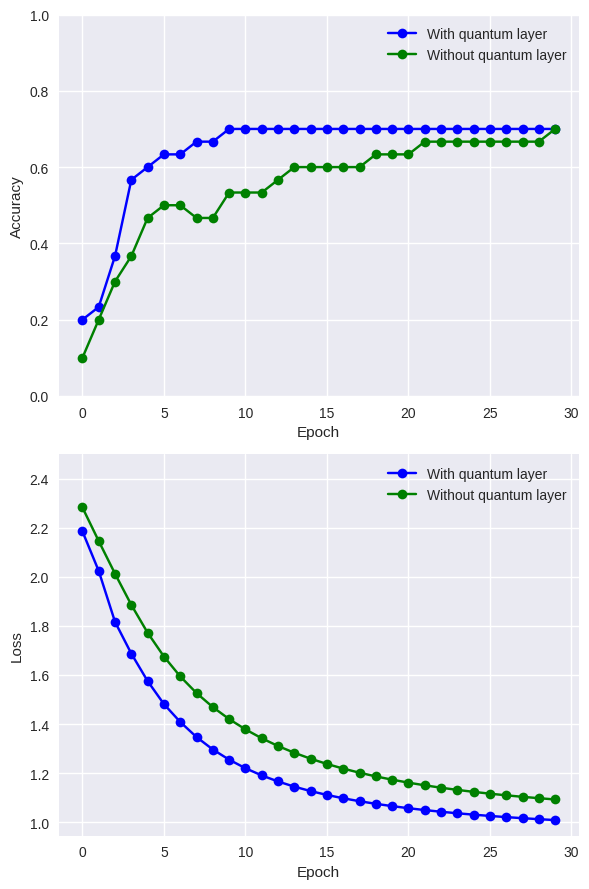

In [21]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()